##  PCA Aanlysis to reduce dimensionality
the aim is to apply PCA and see if improves the results of our trainning model


**Cohort:** mar23_accidents

**Author:** Tiago Russomanno

**Date:** 25 October 2023

### Modelr with target variable severe  *** tested with Random Forest


-1 step load cleanning data 231018_clean_table_for_analysis.csv

-2 step create variable severe based on  grav

-3 clean the data, leaving only numerical variables

-4 split the dataset

-3 step prepare and run PCA and thest the number of components 

-4 srun your model and see teh results

Load Libraries

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

Load datset

In [2]:
df = pd.read_csv('./data/231030_clean_table_for_analysis.csv', low_memory = False, index_col = 0)

data description

In [3]:
df.head(5)

,place,catu,grav,sexe,an_nais,trajet,locp,an,mois,jour,...,manv,date,is_holiday,holiday,datetime,actp,num_veh,etatp,day_of_week,hour_of_day
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,2.0,2,4,2,2002,0.0,-1.0,2019,11,30,...,23.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,14,0,5,1
201900000001,1.0,1,4,2,1993,5.0,-1.0,2019,11,30,...,23.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,14,0,5,1
201900000001,1.0,1,1,1,1959,0.0,-1.0,2019,11,30,...,11.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,0,0,5,1
201900000002,1.0,1,4,2,1994,0.0,-1.0,2019,11,30,...,0.0,2019-11-30,False,NaN,2019-11-30 02:50:00,0,0,0,5,2
201900000003,1.0,1,1,1,1996,0.0,-1.0,2019,11,28,...,2.0,2019-11-28,False,NaN,2019-11-28 15:15:00,1,0,0,3,15


Preparing the dataset

In [4]:
df = df.assign(date = pd.to_datetime(df['date']))
df['date'] = df.apply(lambda x: int(x['date'].timestamp()), axis = 1)

In [47]:
# Fixing the hrmn issue:
# Transform `date`
#df = df.assign(date = pd.to_datetime(df['date']))
#df = df.assign(hrmn = pd.to_datetime(df['hrmn']))

In [48]:
#df['date'] = df.apply(lambda x: int(x['date'].timestamp()), axis = 1)
#df['hrmn'] = df.apply(lambda x: int(x['hrmn'].timestamp()), axis = 1)

Creating the target variable "severe"

In [5]:
df.grav.unique()

array([4, 1, 2, 3], dtype=int64)

In [6]:
#df['severe'] = np.where(df['grav'].isin([0, 1]), 0, 1)
df['severe'] = np.where(df['grav'].isin([1, 2]), 0, 1)

In [7]:
df.severe.unique()

array([1, 0])

Checking the distribution of the target variable

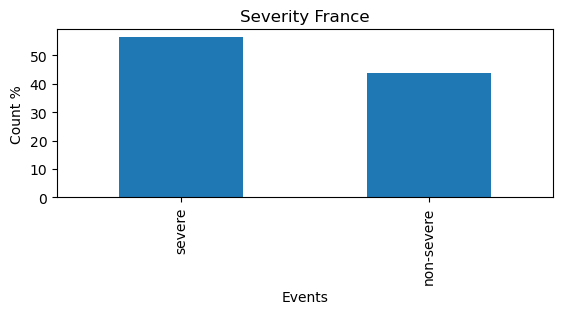

In [8]:
# checking the variables graphically and their distribution
import matplotlib.pyplot as plt
# exploring severe cases in % 
event_counts = df['severe'].value_counts()
event_percentages = (event_counts / event_counts.sum()) * 100
plt.subplot(2,1,1)
event_percentages.plot.bar()
labels = ['severe','non-severe']
# Add labels and title to the plot
plt.xticks(range(len(event_counts)), labels)
plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Severity France')
# Display the plot
plt.show()

Filtering teh varaibles that will not be used in the model and in the PCA

In [9]:
#columns_drop = ['holiday', 'grav','datetime','is_holiday','day_of_week']

#df.drop(columns = columns_drop, inplace = True)

columns_drop = ['holiday', 'hrmn', 'datetime']

df.drop(columns = columns_drop, inplace = True)

In [10]:
df.head()

,place,catu,grav,sexe,an_nais,trajet,locp,an,mois,jour,...,choc,manv,date,is_holiday,actp,num_veh,etatp,day_of_week,hour_of_day,severe
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,2.0,2,4,2,2002,0.0,-1.0,2019,11,30,...,5.0,23.0,1575072000,False,0,14,0,5,1,1
201900000001,1.0,1,4,2,1993,5.0,-1.0,2019,11,30,...,5.0,23.0,1575072000,False,0,14,0,5,1,1
201900000001,1.0,1,1,1,1959,0.0,-1.0,2019,11,30,...,3.0,11.0,1575072000,False,0,0,0,5,1,0
201900000002,1.0,1,4,2,1994,0.0,-1.0,2019,11,30,...,1.0,0.0,1575072000,False,0,0,0,5,2,1
201900000003,1.0,1,1,1,1996,0.0,-1.0,2019,11,28,...,1.0,2.0,1574899200,False,1,0,0,3,15,0


In [11]:
df.drop('grav', axis = 1, inplace = True)
df.head()

,place,catu,sexe,an_nais,trajet,locp,an,mois,jour,lum,...,choc,manv,date,is_holiday,actp,num_veh,etatp,day_of_week,hour_of_day,severe
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,2.0,2,2,2002,0.0,-1.0,2019,11,30,4,...,5.0,23.0,1575072000,False,0,14,0,5,1,1
201900000001,1.0,1,2,1993,5.0,-1.0,2019,11,30,4,...,5.0,23.0,1575072000,False,0,14,0,5,1,1
201900000001,1.0,1,1,1959,0.0,-1.0,2019,11,30,4,...,3.0,11.0,1575072000,False,0,0,0,5,1,0
201900000002,1.0,1,2,1994,0.0,-1.0,2019,11,30,3,...,1.0,0.0,1575072000,False,0,0,0,5,2,1
201900000003,1.0,1,1,1996,0.0,-1.0,2019,11,28,1,...,1.0,2.0,1574899200,False,1,0,0,3,15,0


### Preparation of the training and test datasets
#### Split data
The dataset is split by year slides. We decided to drop the Covid-19 years 2020-21. The years 2005 to 2017 are selected for the train dataset and the years 2018 and 2019 for the test dataset. Furthermore, the `grav` variable was dropped because it is encoded in `severe`.

In [12]:
# split the dataset to train and test data
X_train = df.loc[df['an'] < 2018]
X_train = X_train.drop('severe', axis = 1)

X_test = df[(df['an'] >= 2018) & (df['an'] < 2020)]
X_test = X_test.drop('severe', axis = 1)

y_train = df['severe'].loc[df['an'] < 2018]
y_test = df['severe'][(df['an'] >= 2018) & (df['an'] < 2020)]

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [13]:
# checkimg for non numeric columns
non_numeric_columns = df.select_dtypes(exclude='number')

In [14]:
non_numeric_columns

,is_holiday
Num_Acc,
201900000001,False
201900000001,False
201900000001,False
201900000002,False
201900000003,False
...,...
201800055764,False
201800055765,False
201800055765,False


## First step to PCA
standardize the data

In [15]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



## Second step

create a fit model with N number of components and plot and evaluate visually the "elbow" of the curve where ate least 90% of the 
variance is explained

In [16]:
# Create and fit the PCA model
n_components = 30  # need to test until fnd the right valeu based on the graphic 27 look like the best value to explain the variance 
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

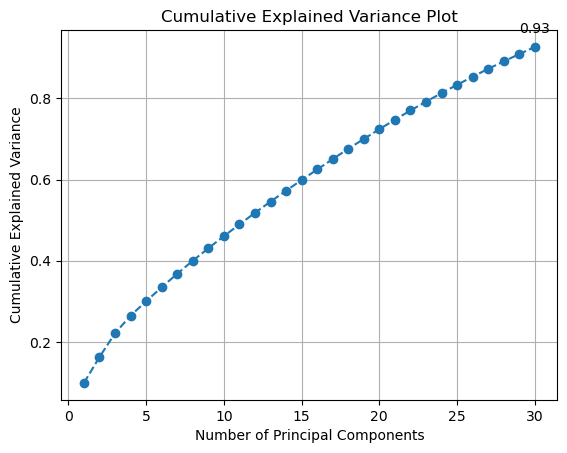

In [17]:
cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')

# Annotate the last point with the cumulative variance value
last_point = (n_components, cumulative_variance[-1])
plt.annotate(f'{cumulative_variance[-1]:.2f}', last_point, textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid()
plt.show()



## At this point you should include and run your model to test if the PCA improve the results
 
### Modelling the data using a Randon Forest classifier with 100 estimators

In [18]:
# Create and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

In [19]:
# Make predictions
y_pred = clf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Other evaluation metrics
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 69.29%
              precision    recall  f1-score   support

           0       0.69      0.56      0.62    111446
           1       0.70      0.79      0.74    140377

    accuracy                           0.69    251823
   macro avg       0.69      0.68      0.68    251823
weighted avg       0.69      0.69      0.69    251823

Confusion Matrix:
[[ 62945  48501]
 [ 28842 111535]]


# old PCA before Tobias changes in notebook 1 and 2
Accuracy: 70.85%
              precision    recall  f1-score   support

           0       0.69      0.61      0.65    111446
           1       0.72      0.78      0.75    140377

    accuracy                           0.71    251823
   macro avg       0.71      0.70      0.70    251823
weighted avg       0.71      0.71      0.71    251823

Confusion Matrix:
[[ 68487  42959]
 [ 30458 109919]]

## results from the model without PCA
 so far the PCA did not improve the results
 
[Random Forest Algorithm] Accuracy Score: 0.776

Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.73      0.74    111446
           1       0.79      0.81      0.80    140377

    accuracy                           0.78    251823

    macro avg      0.77      0.77      0.77    251823
    
    weighted avg   0.78      0.78      0.78    251823

## conclusion
 there was no  improvemnt on the accuracy of the model using PCA
 the Random Forest had an accuracy of 0.78 without PCA and 0.69 with PCA
